Реализовать (самостоятельно продифференцировать и описать алгоритм градиентного спуска) модели логистической регрессии для бинарной и небинарной классификации. Сравнить производительность с референсными реализациями (например, sklearn). Используя двумерные данные, отобразить границы принятия решения (линейные разделители) для реализованных моделей. Проверить реализации на задачах из первой части.

## 1. Бинарная классификация

In [24]:
import numpy as np
import pandas as pd

df = pd.read_csv("dataset_admins.csv", delimiter=",")
df.head()

,First exam,Second exam,Admin
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [25]:
X = df.values[:, :2]
y = df.values[:, 2].astype(int)

### Sklearn бинарный классификатор

In [26]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression(solver='lbfgs')
result = model.fit(X, y)

In [27]:
w1, w0, b = result.coef_[0, 1], result.coef_[0, 0], result.intercept_[0]

print("Score:", result.score(X, y))
print("w1:", w1, "w0:", w0, "b:", b)

Score: 0.89
w1: 0.20058380395530148 w0: 0.20535491218577984 b: -25.052193143127447


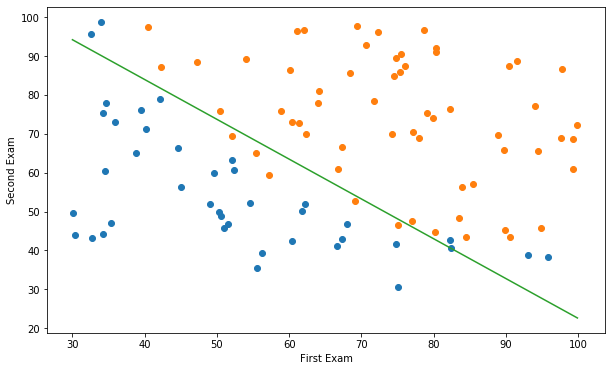

In [28]:
import matplotlib.pyplot as plt

not_admin = df.loc[df["Admin"] == 0]
admin = df.loc[df["Admin"] == 1]

fig, ax = plt.subplots(figsize=(10 , 6))

ax.scatter(not_admin.values[:, 0], not_admin.values[:, 1])
ax.scatter(admin.values[:, 0], admin.values[:, 1])

# Линейный разделитель
xs = np.arange(30, 100, 0.1)
ys = -(b + np.dot(w0, xs)) / w1

ax.plot(xs, ys, color="C2")

ax.set_xlabel("First Exam")
ax.set_ylabel("Second Exam")

plt.show()

### Собственная реализация бинарного класификатора

$$L(\vec{w}, b) = -\frac{1}{N}\sum_{i=1}^{N}( y_{i}\:log(sigmoid(\vec{w}\cdot \vec{x} + b)) + (1 - y_{i})\:log(1-sigmoid(\vec{w}\cdot \vec{x} + b)))$$ $$sigmoid(x)=\frac{1}{1+e^{-x}}$$

Для реализации градиентного спуска необходимо найти частные производные по всем весам. Для удобства, пусть $\vec{\theta} = \left \{w_1, w_2, ...\: , w_m, b \right \}$ и $\vec{x^{(i)}}=\left \{ x_1^{(i)}, x_2^{(i)}, ...\:, x_m^{(i)}, 1 \right \}$. Тогда,

$$\frac{\partial L(\vec{\theta})}{\partial \theta_{j}} = -\frac{1}{N}\sum_{i=1}^{N} \left [ y^{(i)}\: \frac{\partial}{\partial \theta_{j}} log(sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})) + (1 - y^{(i)})\:\frac{\partial}{\partial \theta_{j}} log(1-sigmoid(\vec{\theta}\cdot \vec{x^{(i)}}))\right ] =  $$

$$=-\frac{1}{N}\sum_{i=1}^{N} \left [ y^{(i)}\: \frac{\frac{\partial}{\partial \theta_{j}} sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})}{sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})} + (1 - y^{(i)})\:\frac{\frac{\partial}{\partial \theta_{j}} (1 - sigmoid(\vec{\theta}\cdot \vec{x^{(i)}}))}{1-sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})}\right ]=$$

Где производная, $$\frac{d}{dx}sigmoid(x)=\frac{d}{dx}\left(\frac{1}{1+e^{-x}}\right)=
\frac{-(1+e^{-x})'}{(1+e^{-x})^2}=
\frac{e^{-x}}{(1+e^{-x})^2}=
\left(\frac{1}{1+e^{-x}}\right)\left(\frac{e^{-x}}{1+e^{-x}}\right)=
\left(\frac{1}{1+e^{-x}}\right)\,\left(\frac{1+e^{-x}}{1+e^{-x}}-\frac{1}{1+e^{-x}}\right)=
sigmoid(x)\,\left(\frac{1+e^{-x}}{1+e^{-x}}-sigmoid(x)\right)=
sigmoid(x)\,(1-sigmoid(x))$$
После чего получаем,

$$=-\frac{1}{N}\sum_{i=1}^{N} \left [ y^{(i)} \frac{sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})(1-sigmoid(\vec{\theta}\cdot \vec{x^{(i)}}))\frac{\partial}{\partial \theta_{j}}(\vec{\theta}\cdot \vec{x^{(i)}})} {   sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})}+(1 - y^{(i)})\frac {    sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})    (1-sigmoid(\vec{\theta}\cdot \vec{x^{(i)}}))\frac{\partial}{\partial \theta_{j}}(\vec{\theta}\cdot\vec{x^{(i)}})} {   1-sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})} \right ]=$$

$$ =-\frac{1}{m}\sum_{i=1}^{m}\left [ y^{(i)}(1-sigmoid(\vec{\theta}\cdot \vec{x^{(i)}}))x_j^{(i)} -(1-y^{(i)})sigmoid(\vec{\theta}\cdot \vec{x^{(i)}})x_j^{(i)} \right ]=\frac{1}{m}\sum_{i=1}^{m}\left [(sigmoid(\vec{\theta}\cdot \vec{x^{(i)}}) - y^{(i)})x_j^{(i)} \right ]$$

In [6]:
class MyBinaryLogisticRegression:
    def __init__(self, alpha=0.05, max_iters=5e5, eps=1e-2):
        self._alpha = alpha
        self._max_iters = int(max_iters)
        self._eps = eps
        self._weights = None
    
    def _add_ones_column(self, X):
        return np.append(X, np.ones((X.shape[0], 1)), axis=1) 
    
    def _sigmoid(self, z):
        return 1.0 / (1 + np.exp(-z))
    
    def _loss(self, X, y, w):
        h = self._sigmoid(np.dot(X, w))
        return -(y * np.log(h) + (1 - y) * np.log(1 - h)).mean()
    
    def _loss_derivate(self, X, y):
        # res = np.zeros(X.shape[1])
        # for i in range(len(y)):
        #     z = np.dot(X[i], self._weights)
        #     h = self._sigmoid(z)
        #     for j in range(len(res)):
        #         res[j] += [X[i][j] * (h - y[i])]
        # return res / len(y)
        # Эквивалентно:
        z = np.dot(X, self._weights)
        h = self._sigmoid(z)
        return np.dot(X.T, (h - y)) / len(y)    

    def fit(self, X, y):
        X = self._add_ones_column(X)
        self._weights = np.zeros(X.shape[1])
        
        # Метод градиентного спуска 
        for i in range(self._max_iters):
            gradient = self._loss_derivate(X, y) 
            self._weights -= self._alpha * gradient
            
            if np.linalg.norm(gradient) <= self._eps:
                break
    
    def predict(self, X):
        X = self._add_ones_column(X)
        return self._sigmoid(np.dot(X, self._weights)).round()
    
    def score(self, X, y):
        return (self.predict(X) == y).mean()
    
    def weights(self):
        return self._weights

In [7]:
model = MyBinaryLogisticRegression()
model.fit(X, y)

In [8]:
w1, w0, b = model.weights()

print("Score:", model.score(X, y))
print("w1:", w1, "w0:", w0, "b:", b)

Score: 0.87
w1: 2.1531391015417936 w0: 2.1210349100024586 b: -275.0042600969461


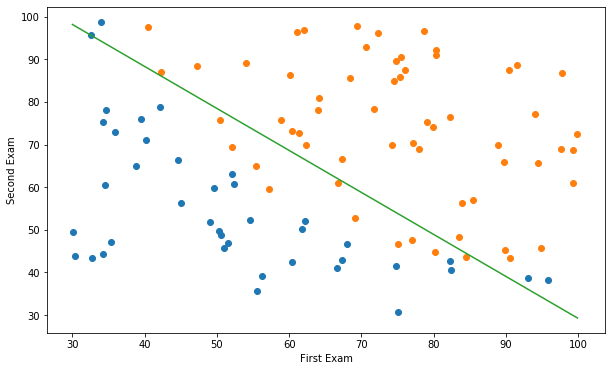

In [9]:
not_admin = df.loc[df["Admin"] == 0]
admin = df.loc[df["Admin"] == 1]

fig, ax = plt.subplots(figsize=(10 , 6))

ax.scatter(not_admin.values[:, 0], not_admin.values[:, 1])
ax.scatter(admin.values[:, 0], admin.values[:, 1])

# Линейный разделитель
xs = np.arange(30, 100, 0.1)
ys = -(b + np.dot(w0, xs)) / w1

ax.plot(xs, ys, color="C2")

ax.set_xlabel("First Exam")
ax.set_ylabel("Second Exam")

plt.show()

## 2. Небинарная классификация (k - классов)

In [10]:
df = pd.read_csv("iris.csv", header=None, names=[
    "Sepal length (cm)",
    "Sepal width (cm)",
    "Petal length (cm)",
    "Petal width (cm)",
    "Species"
])
df = df.drop(["Sepal length (cm)", "Sepal width (cm)"], axis=1)
df["Species"] = df["Species"].astype("category").cat.codes
df.head()

,Petal length (cm),Petal width (cm),Species
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


In [11]:
X = df.values[:, :-1]
y = df.values[:, -1:].astype(int).ravel()

### Sklearn небинарный классификатор (k - классов)

In [12]:
model = LogisticRegression(solver='lbfgs', multi_class='ovr')
result = model.fit(X, y)

In [13]:
W = result.coef_
b = result.intercept_

print("Score:", result.score(X, y))

Score: 0.9666666666666667


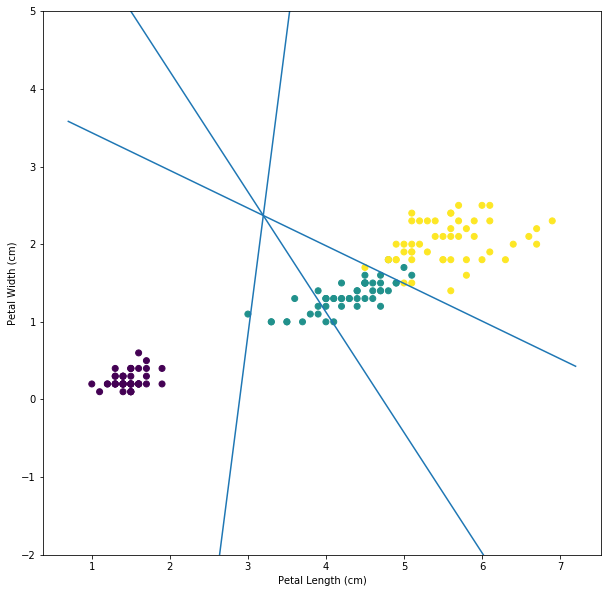

In [14]:
fig, ax = plt.subplots(figsize=(10 , 10))
ax.scatter(X[:,0], X[:, 1], c=y)
ax.set_xlabel("Petal Length (cm)") 
ax.set_ylabel("Petal Width (cm)")
    
# Линейные разделители
xs = np.arange(*plt.xlim(), 0.1)
ys1 = ((b[1] - b[0]) - (W[0, 0] - W[1, 0]) * xs) / (W[0, 1] - W[1, 1])
ys2 = ((b[2] - b[0]) - (W[0, 0] - W[2, 0]) * xs) / (W[0, 1] - W[2, 1])
ys3 = ((b[2] - b[1]) - (W[1, 0] - W[2, 0]) * xs) / (W[1, 1] - W[2, 1])
 
ax.plot(xs, ys1, color="C0")
ax.plot(xs, ys2, color="C0")
ax.plot(xs, ys3, color="C0")

ax.set_ylim(-2, 5)

plt.show()

### Собственная реализация небинарного класификатора (k - классов)

$$L(W, b) = -\frac{1}{N}\sum_{i=1}^{N} log(softmax(W\cdot \vec{x} + \vec{b})_i)$$
$$softmax(\vec{z})_i=\frac{e^{z_i}}{\sum_{j=1}^{k}e^{z_j}}$$

Для реализации градиентного спуска необходимо найти частные производные по всем весам. Для удобства, пусть  
$$W = \begin{bmatrix}
w_{11} & ... & w_{1m} & b_1\\ 
w_{21} & ... & w_{2m} & b_2\\ 
  ...  & ... & ...    & ... \\ 
w_{n1} & ... & w_{nm} & b_m
\end{bmatrix} \:\:\:\:\: \vec{x^{(i)}}=\left \{ x_1^{(i)}, x_2^{(i)}, ...\:, x_m^{(i)}, 1 \right \} $$ Тогда,

$$L(W, b)=-\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C}(y_i=c)\,  log(softmax(y_i=c\: |\: x_i, W))=$$
$$= -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C}(y_i=c)log(\frac{e^{w^{T}_cx_i}}{\sum_{c'=1}^{C}e^{w^{T}_cx_i}})=$$
$$= -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C}(y_i=c)(w^{T}_cx_i-log(\sum_{c'=1}^{C}e^{w^{T}_cx_i}))=$$
$$= -\frac{1}{N}\sum_{i=1}^{N}(\sum_{c=1}^{C}(y_i=c)w^{T}_cx_i-log(\sum_{c'=1}^{C}e^{w^{T}_cx_i}))$$

Откуда,
$$\frac{\partial L(w)}{\partial w_{c,j}} =
 -\frac{1}{N}\sum_{i=1}^{N}(\frac{\partial}{\partial w_{c,j}}\sum_{c=1}^{C}(y_i=c)w^{T}_cx_i-\frac{\partial}{\partial w_{c,j}}log(\sum_{c'=1}^{C}e^{w^{T}_cx_i}))=$$
 $$= -\frac{1}{N}\sum_{i=1}^{N}((y_i=c)x_{i, j}-\frac{e^{w^{T}_cx_i}}{\sum_{c'=1}^{C}e^{w^{T}_cx_i}}x_{i, j})=$$
 $$= -\frac{1}{N}\sum_{i=1}^{N}((y_i=c)-softmax(y_i=c\: |\: x_i, W))x_{i, j}$$

По итогу, $$\frac{\partial L(W)}{\partial W_{j}}=\frac{1}{N}\sum_{i=1}^{N}(softmax(\, y_{i}=j\, |\, x_{i}; W)-\left \{ y_{i}=j \right \})\, x_{i}$$

In [15]:
class MyMultiClassLogisticRegression():
    def __init__(self, alpha=0.05, max_iters=5e5, eps=1e-2):
        self._alpha = alpha
        self._max_iters = int(max_iters)
        self._eps = eps
        self._classes = None
        self._weights = None        

    def _one_hot(self, y):
        Y = np.zeros((y.shape[0], self._classes))
        for i in range(y.shape[0]):
            Y[i, y[i]] = 1
        return Y

    def _add_ones_column(self, X):
        return np.append(X, np.ones((X.shape[0], 1)), axis=1) 
    
    def _softmax(self, x):
        z = np.exp(x)
        return z / np.sum(z, axis=0, keepdims=True)
    
    def _loss_derivate(self, X, y):
        z = np.dot(self._weights, X.T)
        h = self._softmax(z)
        return np.dot(h - y.T, X) / len(y)
    
    def fit(self, X, y):
        # Кол-во классов
        self._classes = len(np.unique(y))
        
        X = self._add_ones_column(X)   
        y = self._one_hot(y)
        
        # Веса (Классы * Признаки)
        self._weights = np.zeros((self._classes, X.shape[1]))        
        
        # Метод градиентного спуска
        for _ in range(self._max_iters):
            gradient = self._loss_derivate(X, y)           
            self._weights -= self._alpha * gradient
            
            if np.linalg.norm(gradient) <= self._eps:
                break
        
    def predict(self, X):
        X = self._add_ones_column(X)
        z = np.dot(self._weights, X.T)
        p = self._softmax(z)
        return np.argmax(p, axis=0)
    
    def score(self, X, y):
        return (self.predict(X) == y).mean()
    
    def weights(self):
        return self._weights

In [16]:
model = MyMultiClassLogisticRegression()
model.fit(X, y)

In [17]:
W = model.weights()[:, :-1]
b = model.weights()[:, -1]

print("Score:", model.score(X, y))

Score: 0.9666666666666667


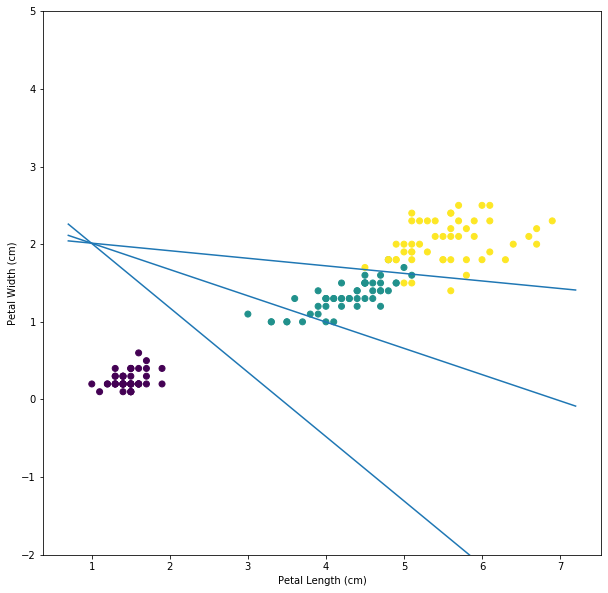

In [18]:
fig, ax = plt.subplots(figsize=(10 , 10))
ax.scatter(X[:,0], X[:, 1], c=y)
ax.set_xlabel("Petal Length (cm)") 
ax.set_ylabel("Petal Width (cm)")

# Линейные разделители
xs = np.arange(*plt.xlim(), 0.1)
ys1 = ((b[1] - b[0]) - (W[0, 0] - W[1, 0]) * xs) / (W[0, 1] - W[1, 1])
ys2 = ((b[2] - b[0]) - (W[0, 0] - W[2, 0]) * xs) / (W[0, 1] - W[2, 1])
ys3 = ((b[2] - b[1]) - (W[1, 0] - W[2, 0]) * xs) / (W[1, 1] - W[2, 1])

ax.plot(xs, ys1, color="C0")
ax.plot(xs, ys2, color="C0")
ax.plot(xs, ys3, color="C0")

ax.set_ylim(-2, 5)

plt.show()